In [116]:
# automatically reload the package when it is modified
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [117]:
import numpy as np
import mediapy
from tqdm import tqdm
import dataclasses

from waymax import config as waymax_config
from waymax import dataloader
from waymax import datatypes
from waymax import visualization

In [308]:
# create a dataset
WOD_1_2_0_TRAIN_LOCAL = waymax_config.DatasetConfig(
    path='/Data/Dataset/Waymo/V1_2_tf/validation_interactive/validation_interactive_tfexample.tfrecord@150',
    max_num_rg_points=30000,
    data_format=waymax_config.DataFormat.TFRECORD,
)

config = dataclasses.replace(WOD_1_2_0_TRAIN_LOCAL, max_num_objects=32)
data_iter = dataloader.simulator_state_generator(config=config)


# Test Multiagent Simulation    

In [ ]:
import jax
from jax import numpy as jnp
import numpy as np
import mediapy
from tqdm import tqdm
import dataclasses

from waymax import config as _config
from waymax import dataloader
from waymax import datatypes
from waymax import dynamics
from waymax import env as _env
from waymax import agents
from waymax import visualization
max_num_objects = 32
from rl_env.sim_agent_actor import SimAgentMTR

In [332]:

# Config the multi-agent environment:
init_steps = 11

# Set the dynamics model the environment is using.
# Note each actor interacting with the environment needs to provide action
# compatible with this dynamics model.
dynamics_model = dynamics.DeltaLocal()

# Expect users to control all valid object in the scene.
env = _env.MultiAgentEnvironment(
    dynamics_model=dynamics_model,
    config=dataclasses.replace(
        _config.EnvironmentConfig(),
        init_steps = init_steps,
        max_num_objects=max_num_objects,
        controlled_object=_config.ObjectType.VALID,
    ),
)
     

In [282]:
@jax.jit
def check_controlled(state: datatypes.SimulatorState):
    current_stamp = state.timestep
    is_valid = state.sim_trajectory.valid[..., current_stamp]
    is_modeled = jnp.logical_or(
        state.object_metadata.is_modeled,
        state.object_metadata.is_sdc
    )
    is_vehicle = (state.object_metadata.object_types == 1)
    
    # print(is_valid)
    # print(is_modeled)
    # print(is_vehicle)
    
    return jnp.logical_and(is_valid, jnp.logical_and(is_modeled, is_vehicle))

In [299]:
# Setup a few actors, see visualization below for how each actor behaves.

# An actor that doesn't move, controlling all objects with index > 4
obj_idx = jnp.arange(max_num_objects)
actor_gt = agents.create_expert_actor(
    dynamics_model=dynamics_model,
    is_controlled_func=lambda state: ~check_controlled(state),
)

actor_policy = SimAgentMTR(
    model_path = 'output/bc_atten_4_freeze/epoch=9-step=302840.ckpt',
    is_controlled_func = check_controlled,
)

actors = [actor_policy, actor_gt]


jit_step = env.step #jax.jit(env.step)
jit_select_action_list = [actor.select_action for actor in actors]

""

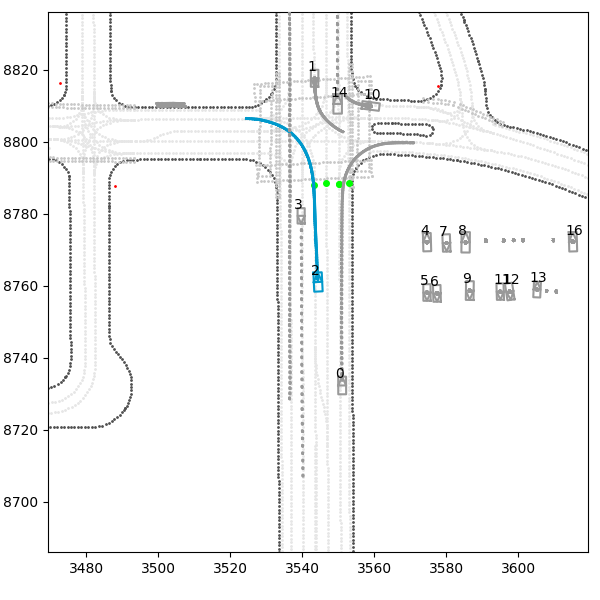

(Array([0, 1], dtype=int32),)


In [341]:
scenario : datatypes.SimulatorState = next(data_iter)
img = visualization.plot_simulator_state(scenario, use_log_traj=True)
mediapy.show_image(img)
print(jnp.where(scenario.object_metadata.is_modeled))

In [347]:
# get a scenario from the dataset
# scenario : datatypes.SimulatorState = next(data_iter)
states = [env.reset(scenario)]
for _ in range(states[0].remaining_timesteps):
  current_state = states[-1]

  gt_output = actor_gt.select_action({}, current_state, None, None)
  policy_output = actor_policy.select_action({}, current_state, None, None)
  action = agents.merge_actions([policy_output, gt_output])
  next_state = jit_step(current_state, action)
  # print(gt_output.action.data[policy_output.is_controlled])
  # print(policy_output.action.data[policy_output.is_controlled])
  # print(action.data[policy_output.is_controlled])
  states.append(next_state)
  
print("Sim Agent Ids:", jnp.where(policy_output.is_controlled))

Sim Agent Ids: (Array([0, 1, 2], dtype=int32),)


In [348]:
imgs = []
for state in states:
  imgs.append(visualization.plot_simulator_state(state, use_log_traj=False))
mediapy.show_video(imgs, fps=10)